# `strymread` tutorial
## Analyzing CAN data logged from Giraffee and Panda

### Prerequisite
- Install strym package from git: `pip install git+https://github.com/jmscslgroup/strym.git`
A detailed instruction about installation is available at https://github.com/jmscslgroup/strym/blob/master/README.md

In [1]:
import strym
from strym import strymread
from strym import ranalyze
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import strym.DBC_Read_Tools as dbc
import numpy as np
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (16,8)
rcParams.update({'font.size': 40})
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
csvfile = '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_04_02/2020-04-02-09-33-00_CAN_Messages.csv'
r =strymread(csvfile=csvfile, dbcfile=dbcfile)

Loading BokehJS ...

## We will visualize the counts of all messages
The plot is split into several subplots for brevity.

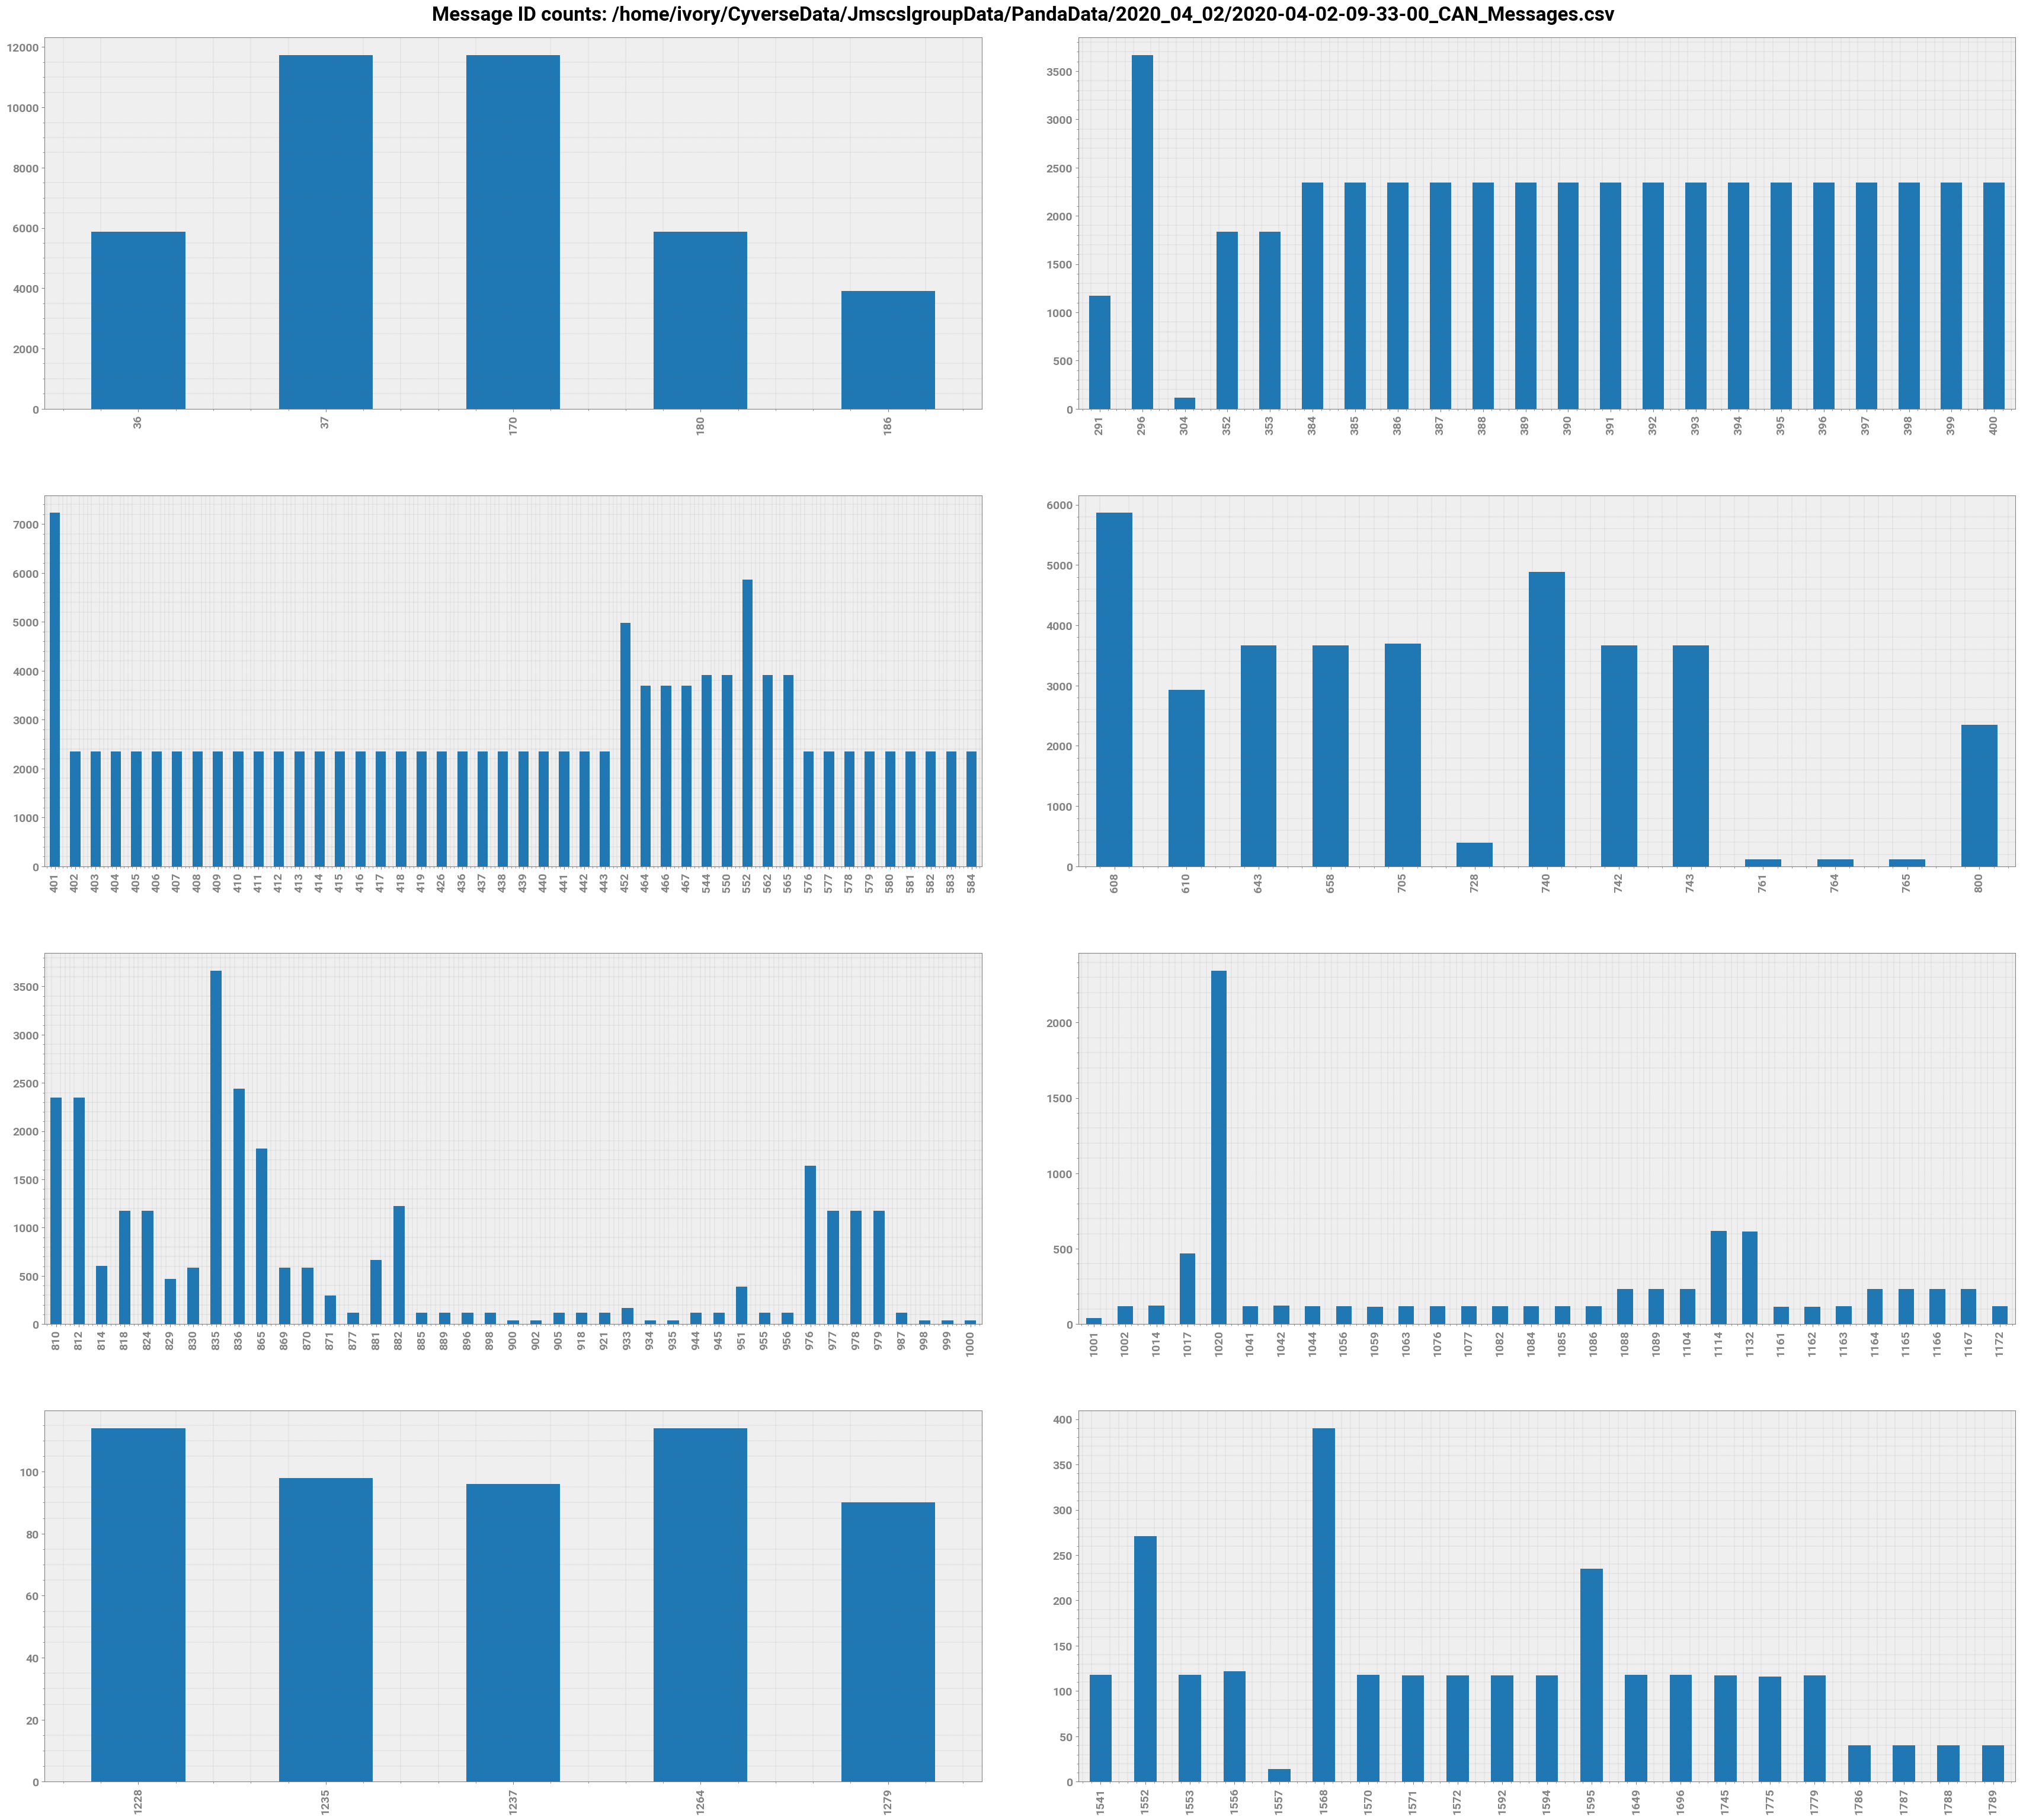

In [2]:
r.count()

## Let's plot a few important data
### Speed

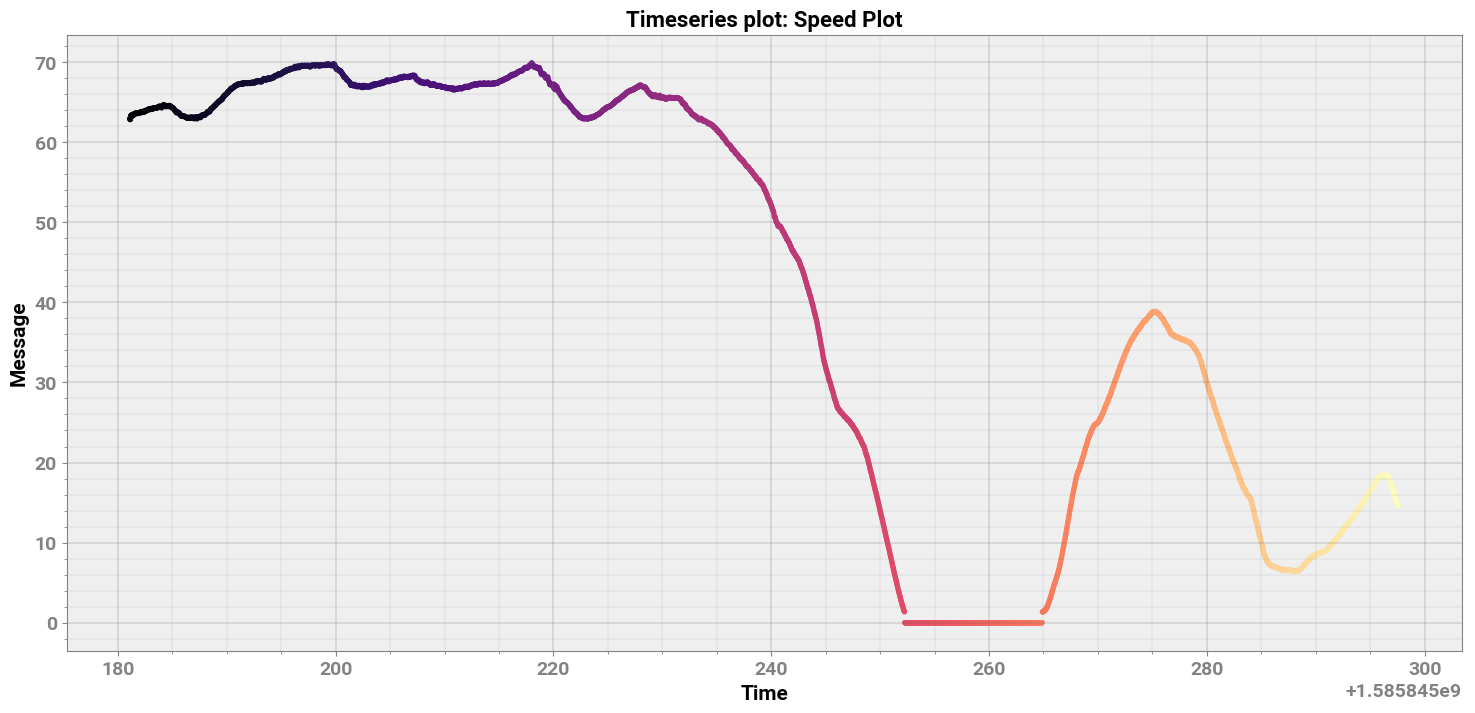

In [3]:
speed = r.speed()
strym.plt_ts(speed, title="Speed Plot")

## Lets visualize a message with given message ID and  signal ID


In [4]:
msg869 = r.get_ts(869, 6)
msg869

,Time,Message
Clock,,
2020-04-02 16:33:01.141018867,1.585845e+09,252
2020-04-02 16:33:01.159624100,1.585845e+09,252
2020-04-02 16:33:01.178574085,1.585845e+09,252
2020-04-02 16:33:01.196076870,1.585845e+09,252
2020-04-02 16:33:01.251914978,1.585845e+09,252
...,...,...
2020-04-02 16:34:56.653086901,1.585845e+09,252
2020-04-02 16:34:56.852686882,1.585845e+09,252
2020-04-02 16:34:57.052386999,1.585845e+09,252


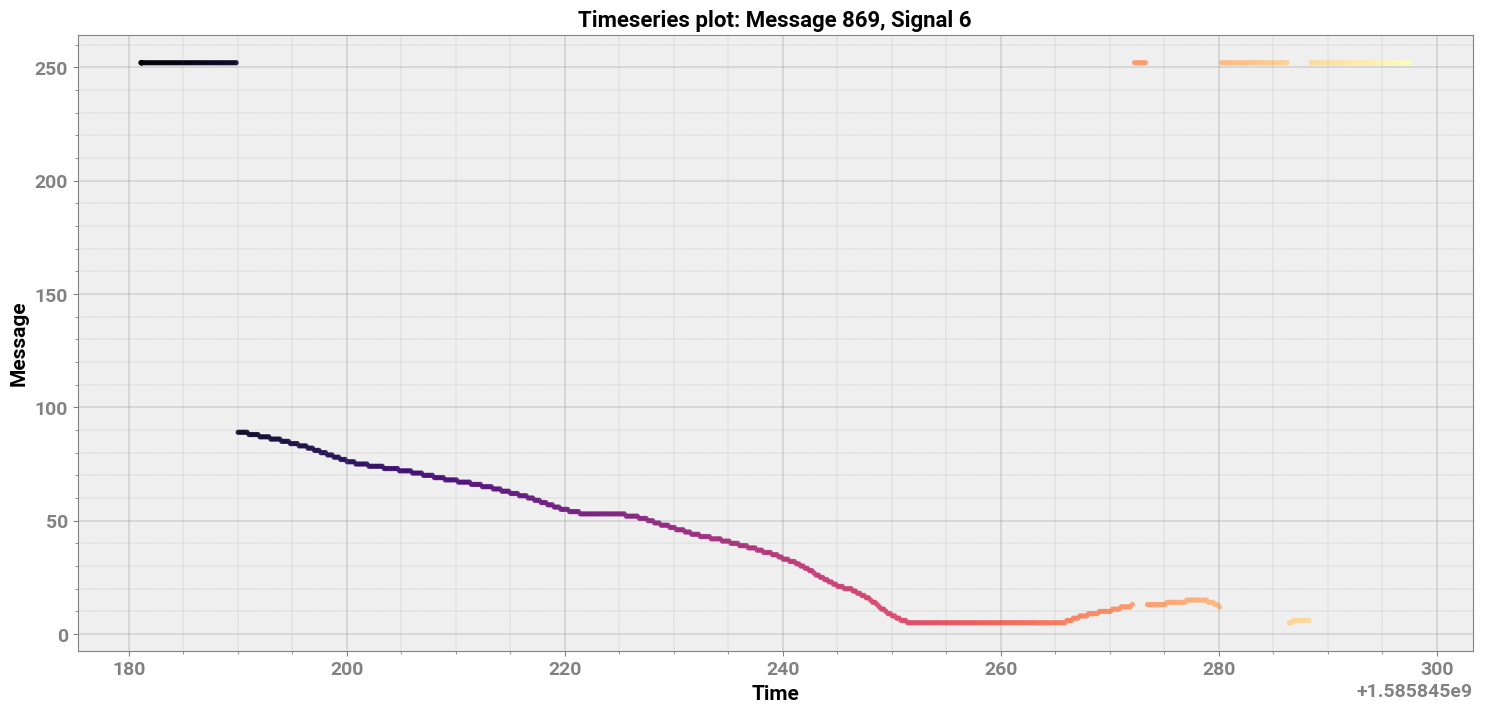

In [5]:
strym.plt_ts(msg869, title="Message 869, Signal 6")

## Rate Statistics for every message ID

In [6]:
u = r.frequency()
u

/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,MessageID,MeanRate,MedianRate,RateStd,MaxRate,MinRate,RateIQR
0,36,54.598520,50.017936,58.421098,1880.010758,18.387763,1.340283
1,37,110.712275,100.047802,138.951407,3731.587189,22.686016,5.699538
2,170,110.650325,100.028714,136.087266,3844.458295,22.290090,4.520423
3,180,54.260494,50.013164,52.652276,1151.016465,21.948560,1.348664
4,186,35.878038,33.336677,30.678480,585.878475,21.950053,1.318849
...,...,...,...,...,...,...,...
178,1779,1.000424,1.000788,0.004532,1.046409,0.997416,0.002976
179,1786,0.336240,0.333364,0.017705,0.445380,0.333190,0.000083
180,1787,0.336195,0.333369,0.017418,0.443566,0.333269,0.000078
181,1788,0.336161,0.333368,0.017207,0.442233,0.333267,0.000060


## Synchronize Two Time Series messages and resample with a fixed datarate


It means first time of speed is earlier than yaw in time-series data so we have to interpolate speed value at yaw's first time. We will use linear interpolation.

Linear interpolation formula is 

$$
X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
$$

In [7]:
ts_yaw_rate = r.yaw_rate()
ts_speed = r.speed()

# integrate yaw rate to get the heading
ts_yaw = strym.integrate(ts_yaw_rate)

In [8]:
interpolated_speed, interpolated_yaw = strym.ts_sync(ts_speed, ts_yaw)

Text(0, 0.5, 'Message')

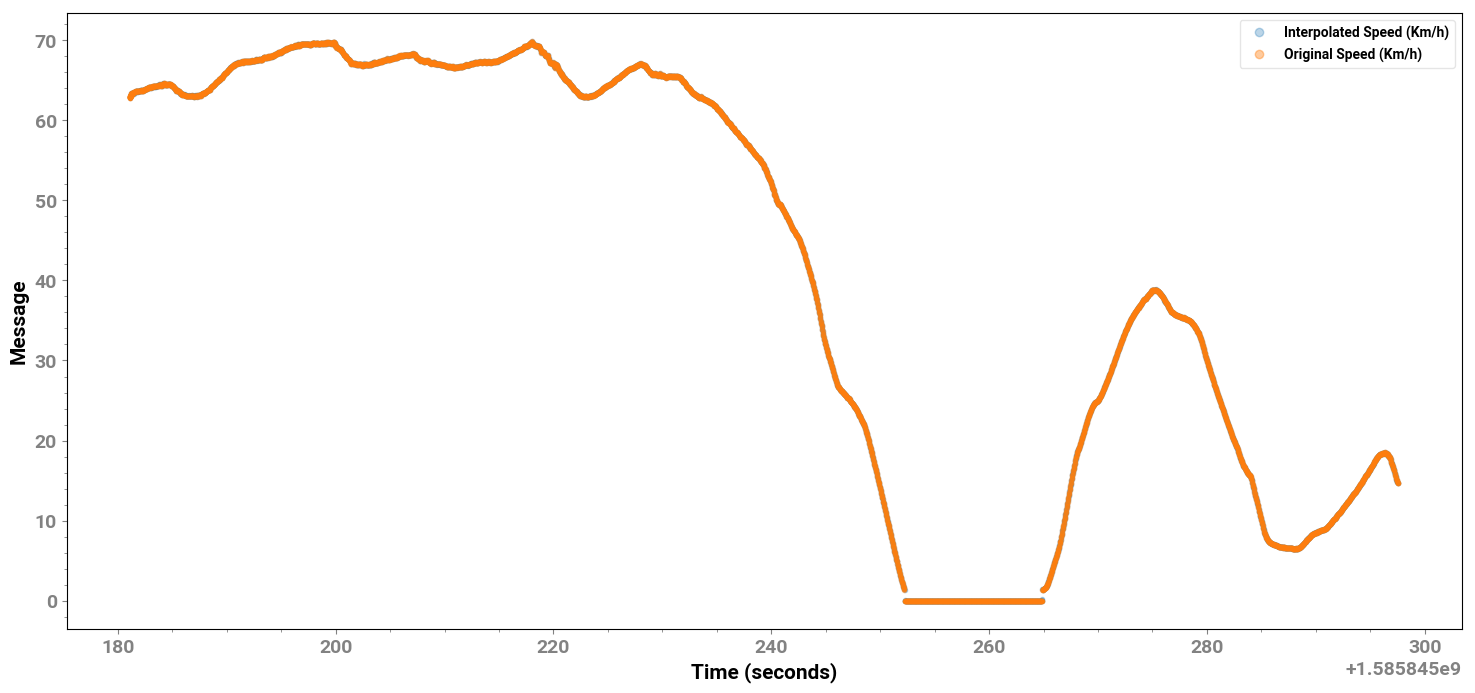

In [9]:
plt.plot(interpolated_speed['Time'], interpolated_speed['Message'], ".", alpha=0.3)
plt.plot(ts_speed['Time'], ts_speed['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Speed (Km/h)', 'Original Speed (Km/h)'])
plt.xlabel('Time (seconds)')
plt.ylabel('Message')

Text(0, 0.5, 'Message')

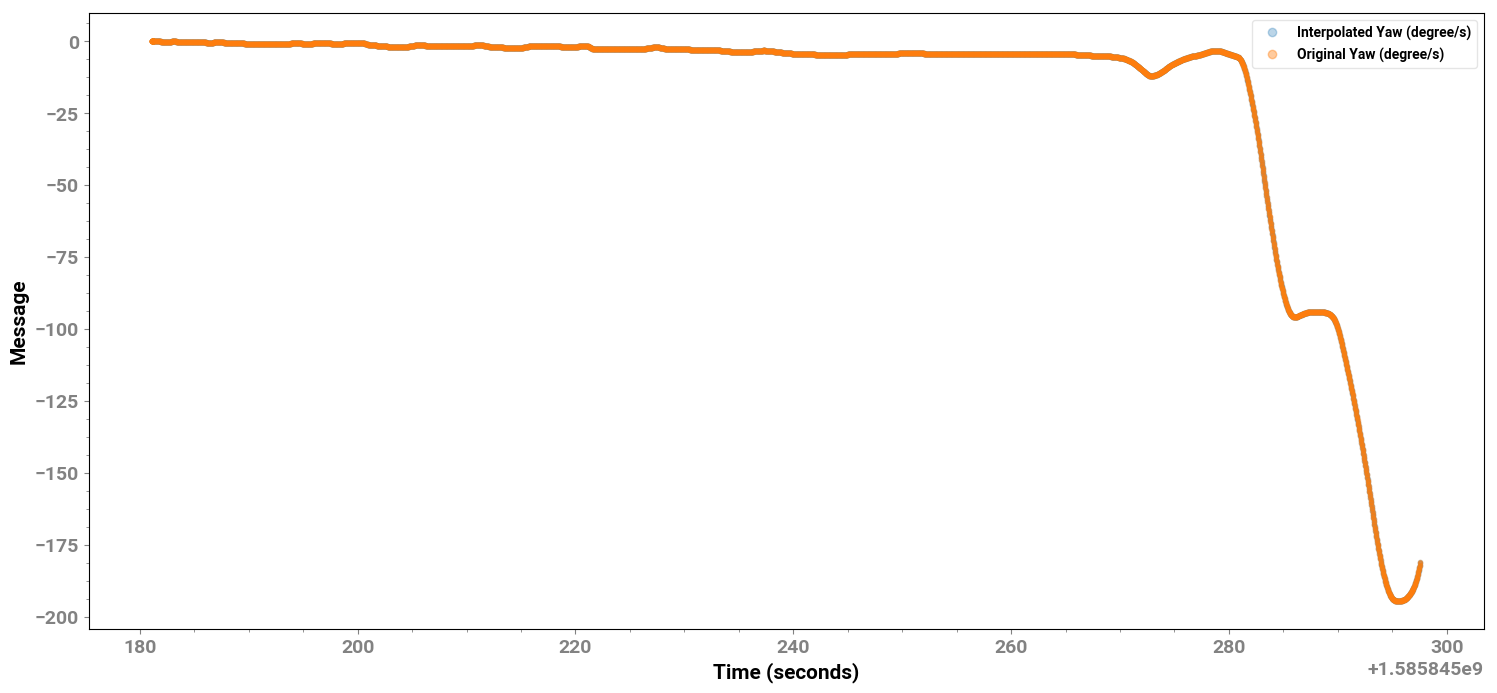

In [10]:
plt.plot(interpolated_yaw['Time'], interpolated_yaw['Message'], ".", alpha=0.3)
plt.plot(ts_yaw['Time'], ts_yaw['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Yaw (degree/s)', 'Original Yaw (degree/s)'])
plt.xlabel('Time (seconds)')
plt.ylabel('Message')

## Plot the trajectory of vehice based on kinematic model using yaw rate and speed

In [11]:
T = r.trajectory()

Text(0, 0.5, 'Y [m]')

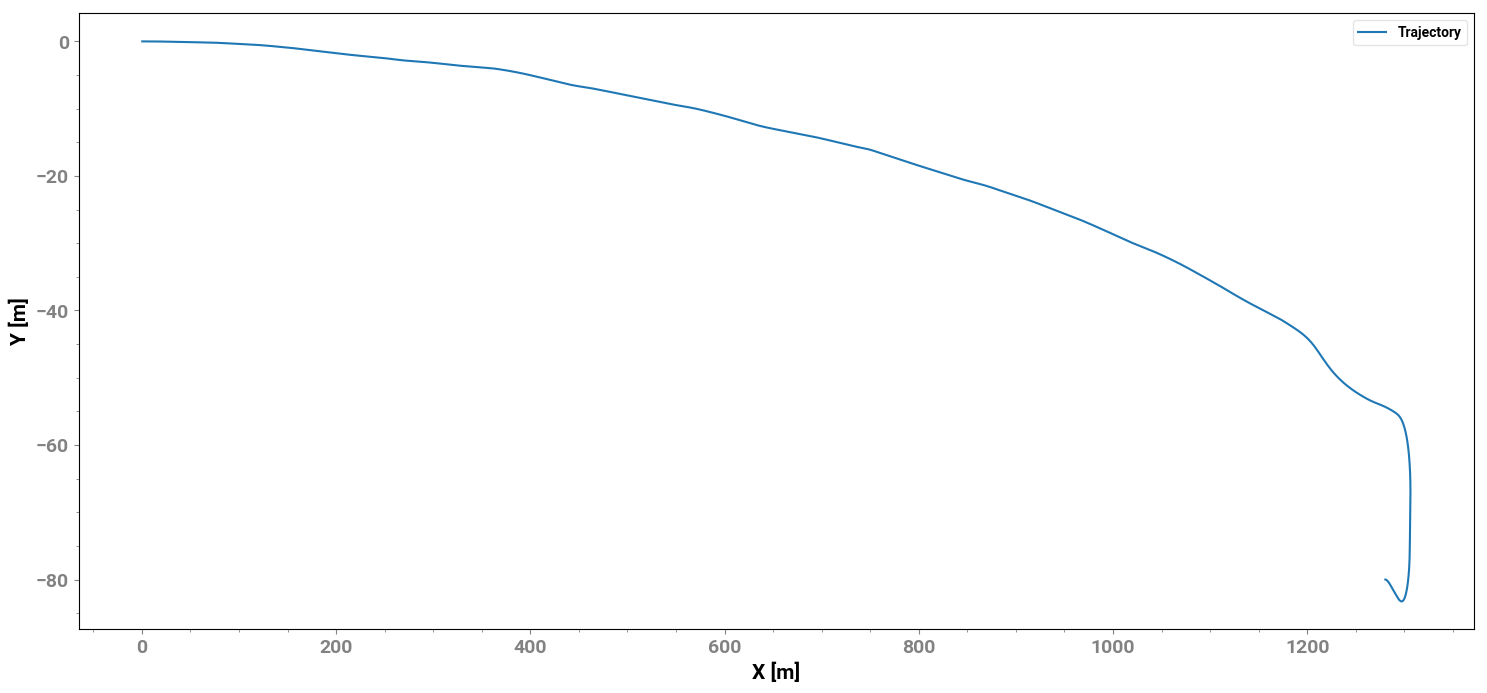

In [12]:
plt.plot(T['X'].iloc[1:7501], T['Y'].iloc[1:7501])
plt.legend(['Trajectory'])
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

In [13]:
T[1:7500]

,Time,X,Y,Vx,Vy
1,1.585845e+09,0.349056,7.249722e-07,17.452778,0.000036
2,1.585845e+09,0.698542,-3.133112e-05,17.474332,-0.001603
3,1.585845e+09,1.048502,-1.716846e-04,17.497993,-0.007018
4,1.585845e+09,1.399448,-3.173906e-04,17.547281,-0.007285
5,1.585845e+09,1.750986,-4.164488e-04,17.576903,-0.004953
...,...,...,...,...,...
5818,1.585845e+09,1280.766308,-7.999746e+01,-4.119258,0.200143
5819,1.585845e+09,1280.684380,-7.999406e+01,-4.096396,0.169997
5820,1.585845e+09,1280.602730,-7.999125e+01,-4.082508,0.140154
5821,1.585845e+09,1280.521215,-7.998904e+01,-4.075735,0.110543


## Get the meta data about driving 

In [14]:
metadata = r.driving_characteristics()

In [15]:
metadata

{'filename': '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_04_02/2020-04-02-09-33-00_CAN_Messages.csv',
 'dbcfile': '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc',
 'distance_meters': 1352.8144978612663,
 'distance_km': 1.3528144978612664,
 'distance_miles': 0.8406020467155892,
 'start_time': 'Thu Apr  2 09:33:01 2020',
 'end_time': 'Thu Apr  2 09:34:57 2020',
 'trip_time': 116.45526313781738}

## Get the distribution of data
### We will show the distribution of speed data

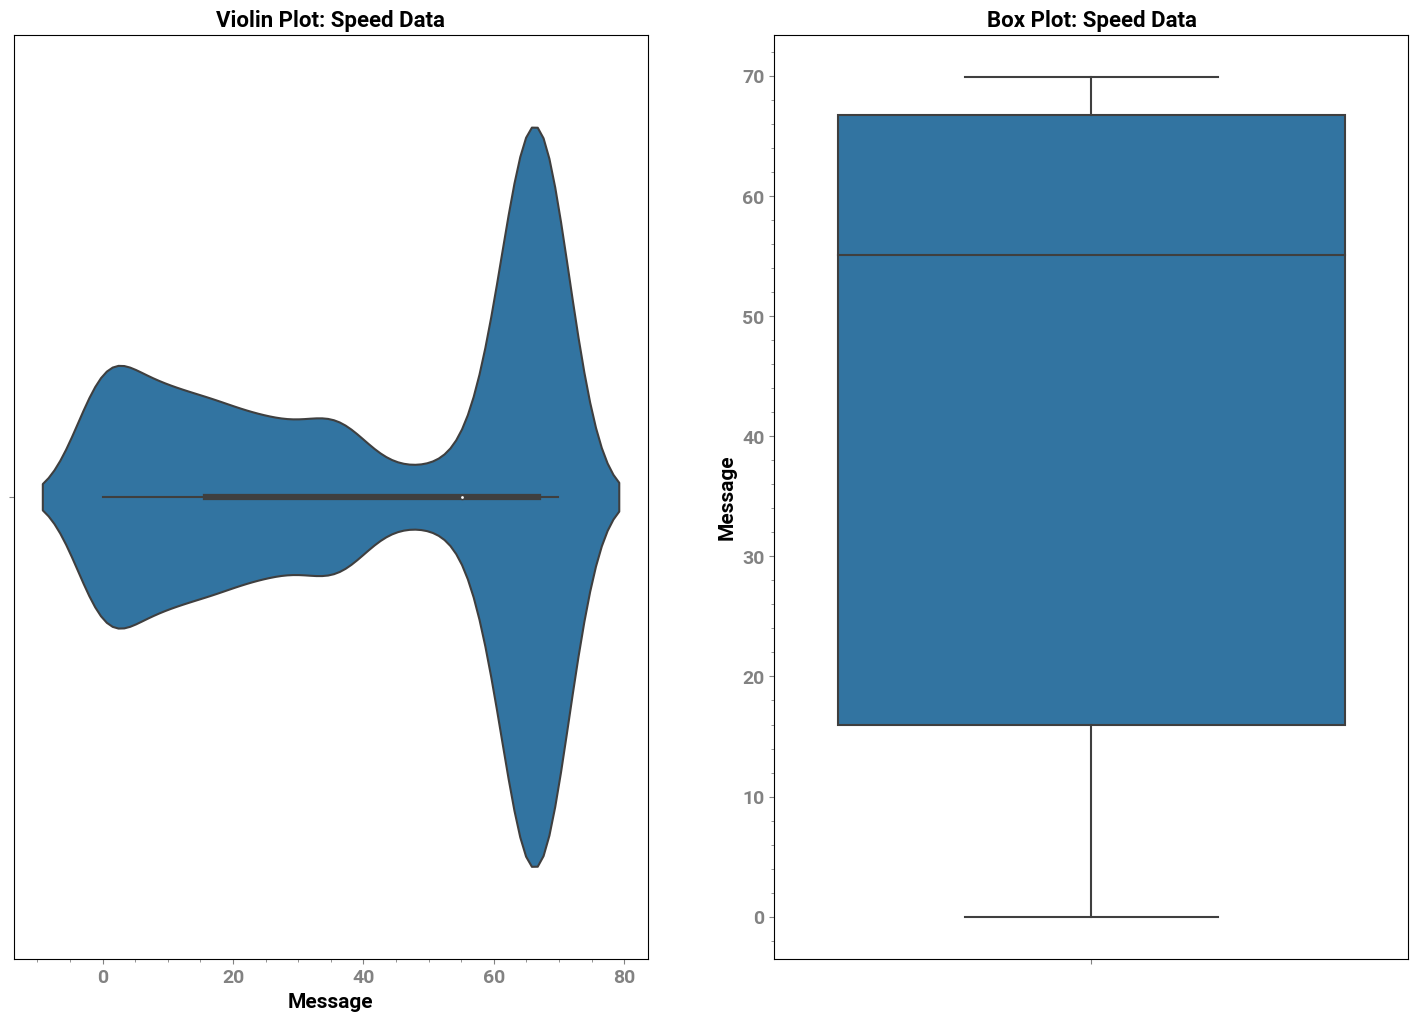

In [16]:
speed = r.speed()
strym.violinplot(speed['Message'], title="Speed Data")

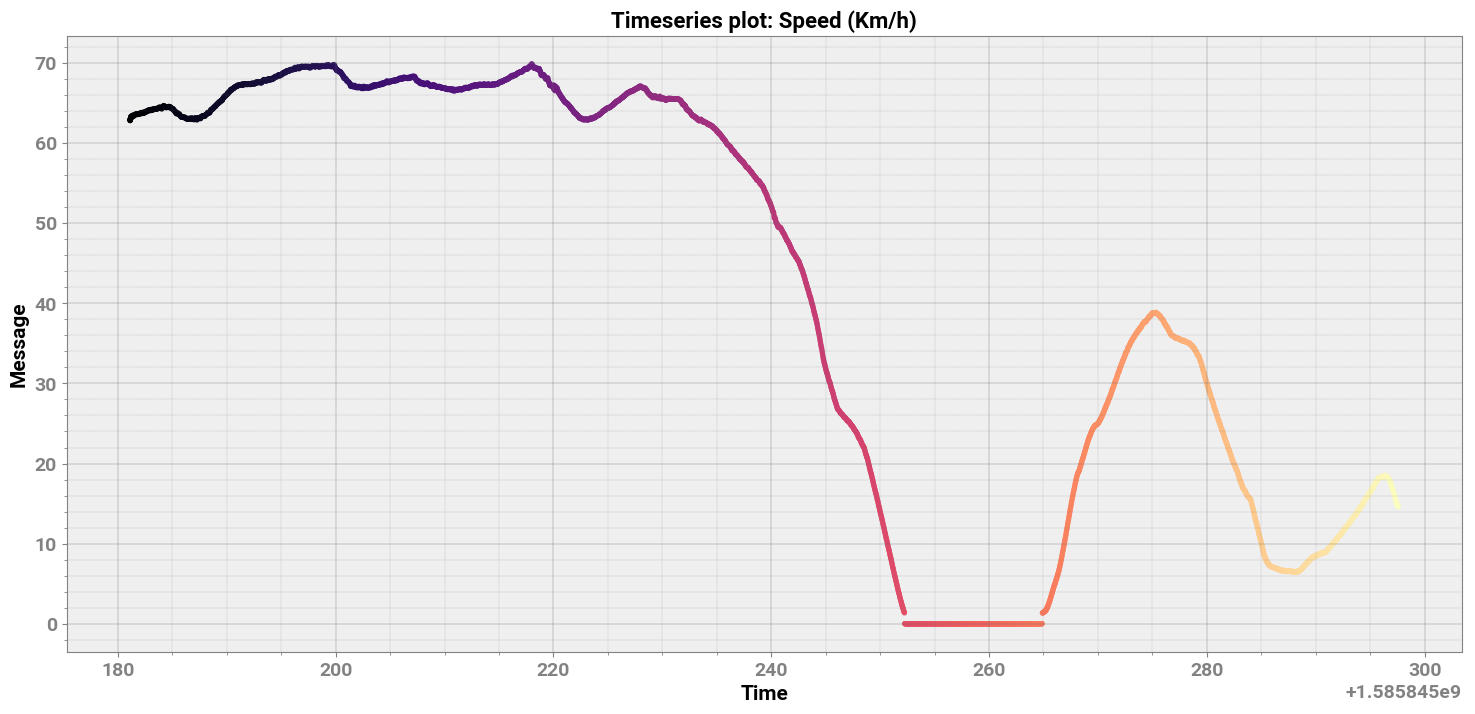

In [17]:
strym.plt_ts(speed, title='Speed (Km/h)')

## Rate Analysis for specific messages
Let's say we want to analyze data throughput aka rate for Radar data.
For this specific example, we will be looking at TRACK_A_0. For that we will call the appropriate function to retreive longitudinal data corresponding to TRACK_A_0.

Analyzing Timestamp and Data Rate of Longitudinal Distance Data: TRACK A 0
Interquartile Range of Rate for Longitudinal Distance Data: TRACK A 0 is 0.19132468401605252 


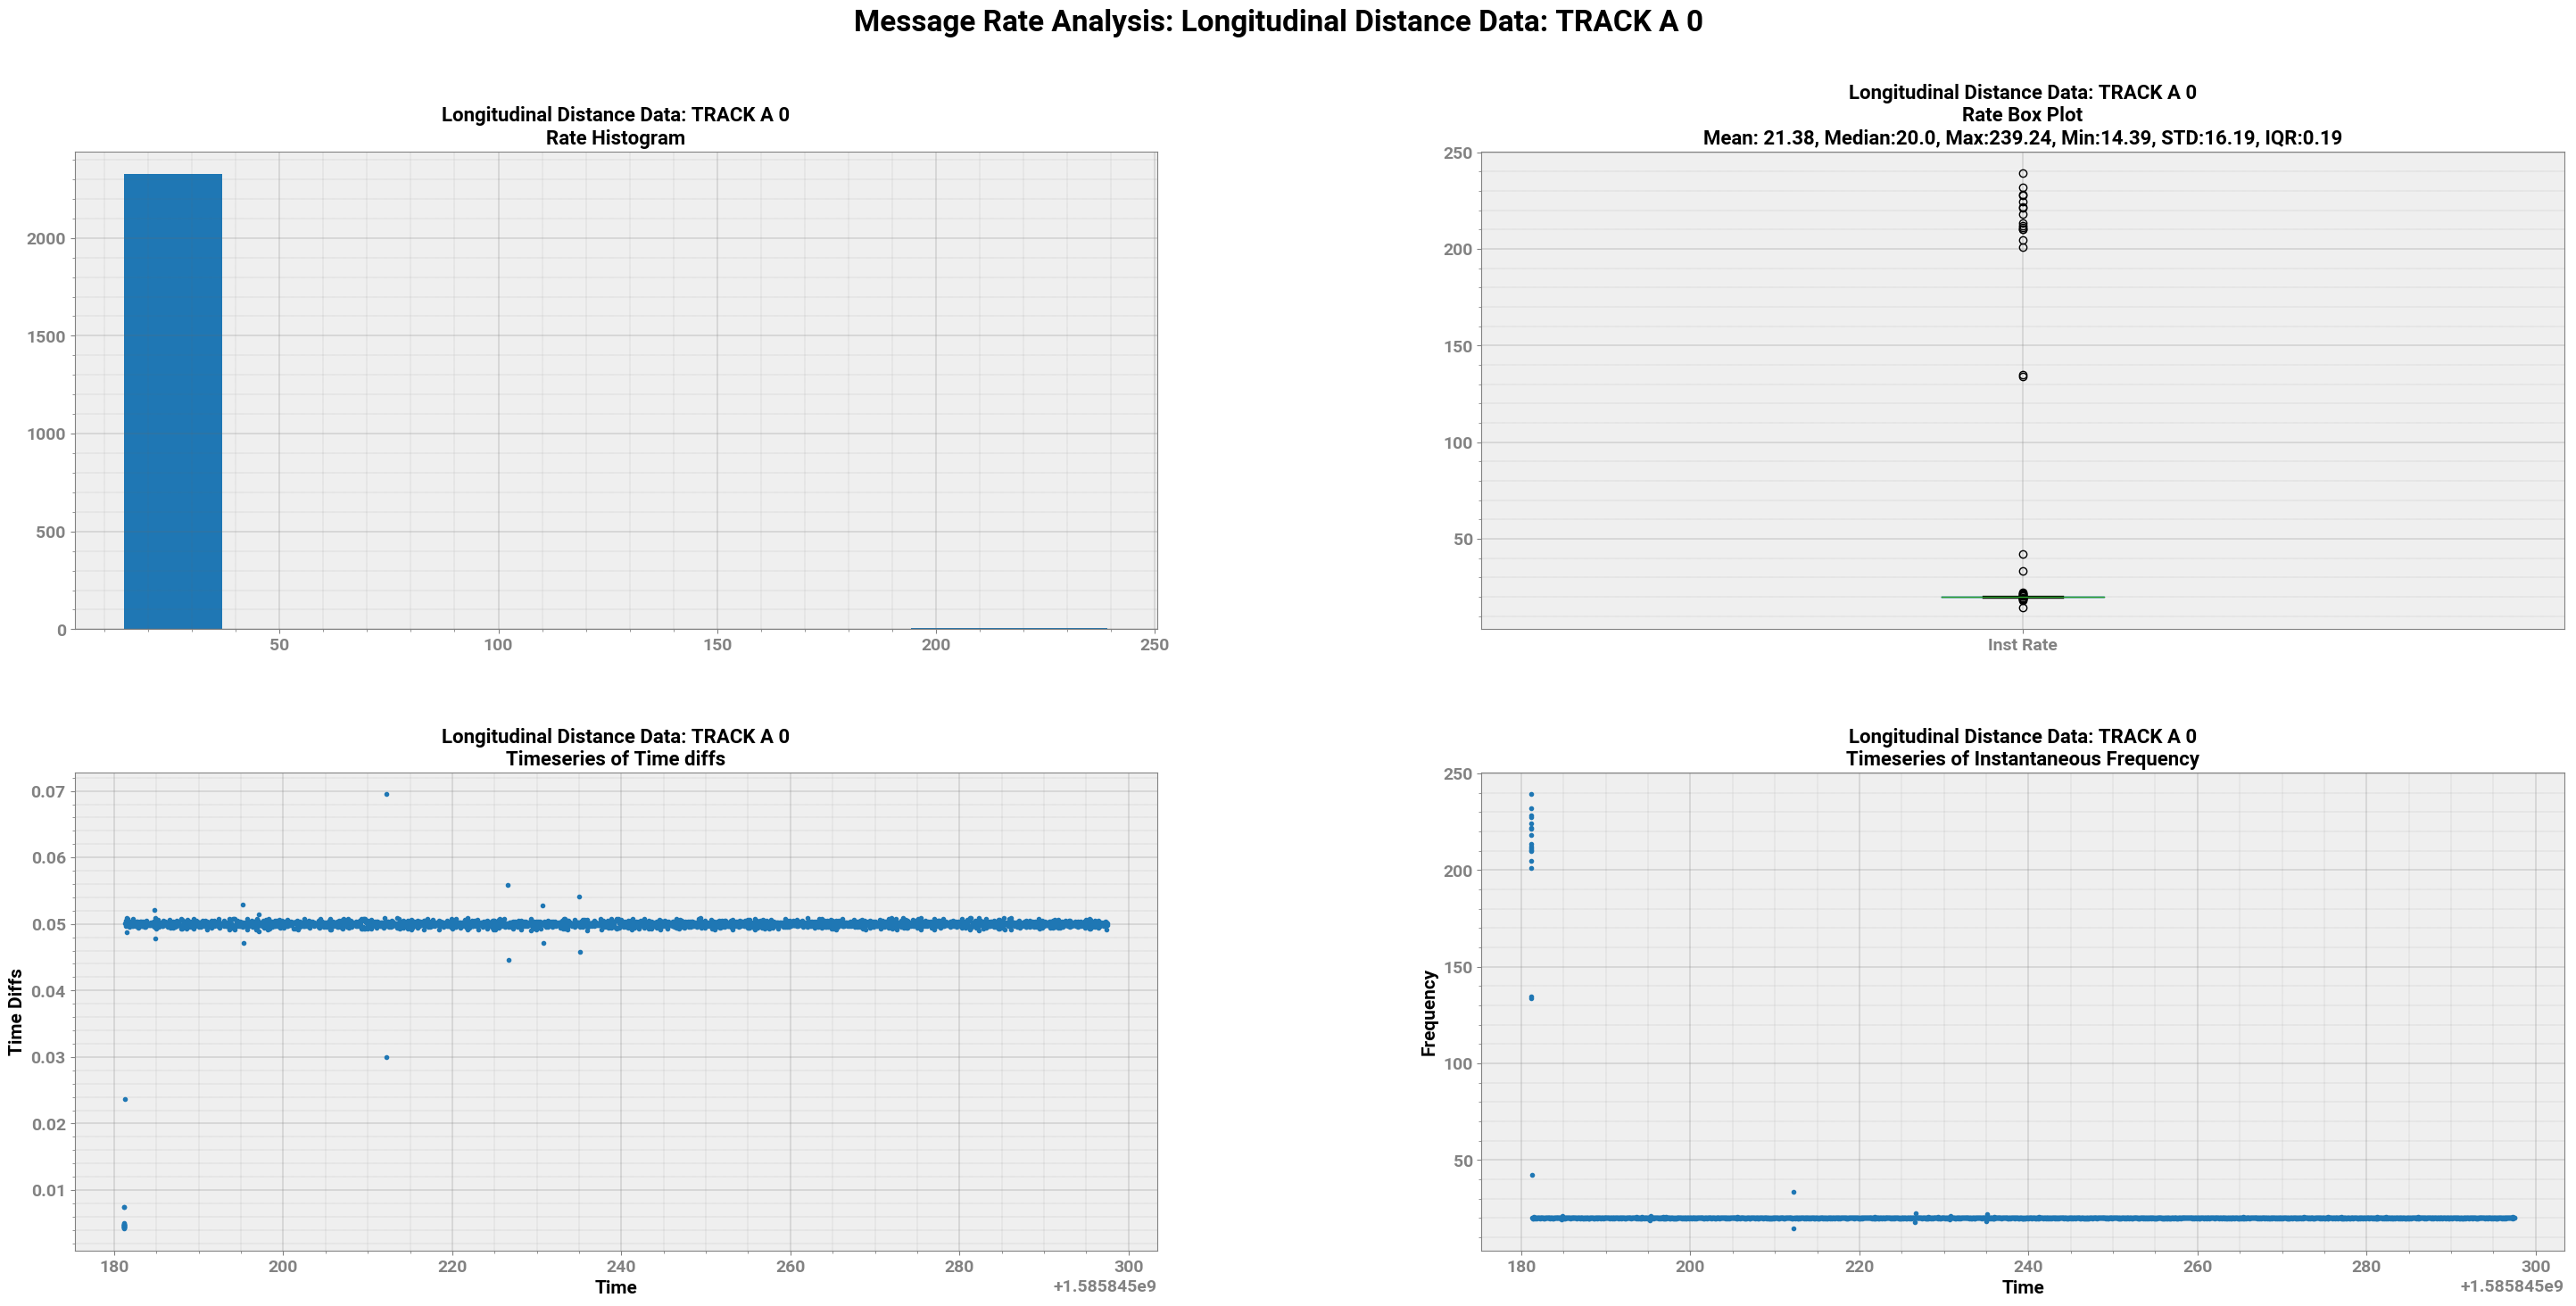

In [18]:
track_id = np.arange(0, 1) # I want to analyze rate for TRACK_A_0 only
long_dist = r.long_dist(track_id)

strym.ranalyze(long_dist[0], title='Longitudinal Distance Data: TRACK A 0')

In [19]:
files = r.extract(force_rewrite=True)

Data file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_04_02/2020-04-02-09-33-00_CAN_Messages.mat already exists
Overwriting ...



/home/ivory/anaconda3/envs/dbn/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Extracting KINEMATICS
	YAW_RATE
	STEERING_TORQUE
	ACCEL_Y
Extracting STEER_ANGLE_SENSOR
	STEER_ANGLE
	STEER_FRACTION
	STEER_RATE
Extracting BRAKE
	BRAKE_AMOUNT
	BRAKE_PEDAL
Extracting WHEEL_SPEEDS
	WHEEL_SPEED_FR
	WHEEL_SPEED_FL
	WHEEL_SPEED_RR
	WHEEL_SPEED_RL
Extracting SPEED
	ENCODER
	SPEED
	CHECKSUM
Extracting UKNOWN186
	UNKNOW186_1
Extracting UKNOWN291
	UNKNOWN291_1
	UNKNOWN291_2
	UNKNOWN291_3
Extracting UKNOWN295
	UNKNOWN295_1
	UNKNOWN295_2
	UNKNOWN295_3
Extracting UKNOWN296
	UNKNOWN296_1
	UNKNOWN296_2
	UNKNOWN296_3
Extracting DSU_SPEED
	FORWARD_SPEED
Extracting STEERING_IPAS_COMMA
	STATE
	ANGLE
	SET_ME_X10
	DIRECTION_CMD
	SET_ME_X40
	SET_ME_X00
	CHECKSUM
Extracting TRACK_A_0
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_1
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_2
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK
	REL_SPEED
	VALID
	CHECKSUM
Extracting TRACK_A_3
	COUNTER
	LONG_DIST
	LAT_DIST
	NEW_TRACK